In [1]:
# check if pyspark works
import pyspark
print(pyspark.__version__)

3.5.1


In [2]:
from pyspark.sql import SparkSession

# Start spark session
spark = SparkSession.builder \
    .appName("Multiclass classification IoT") \
    .getOrCreate()

# Load datasets
def load_test_data(debug=False):
    if debug:
        test_data = spark.read.csv(r"./dataset/NF-ToN-IoT-v2-test.csv", header=True, inferSchema=True).limit(200)
        train_data = spark.read.csv(r"./dataset/NF-ToN-IoT-v2-train.csv", header=True, inferSchema=True).limit(600)
    else:
        test_data = spark.read.csv(r"./dataset/NF-ToN-IoT-v2-test.csv", header=True, inferSchema=True)
        train_data = spark.read.csv(r"./dataset/NF-ToN-IoT-v2-train.csv", header=True, inferSchema=True)
        
    return test_data, train_data

test_data, train_data = load_test_data(debug=True)


In [3]:
# Display the first few rows of the training dataset to verify it's loaded correctly
train_data.show(5)
print(train_data.count())

# Display the first few rows of the testing dataset to verify it's loaded correctly
test_data.show(5)
print(test_data.count())

+-------------+-----------+-------------+-----------+--------+--------+--------+-------+---------+--------+---------+----------------+----------------+--------------------------+-----------+------------+-------+-------+----------------+-----------------+--------------+--------------+-----------------------+-----------------------+----------------------+---------------------+-----------------------+----------------------+-------------------------+-------------------------+------------------------+-------------------------+-------------------------+--------------------------+---------------------------+--------------+---------------+---------+--------------+------------+--------------+--------------+--------------------+-----+--------+
|IPV4_SRC_ADDR|L4_SRC_PORT|IPV4_DST_ADDR|L4_DST_PORT|PROTOCOL|L7_PROTO|IN_BYTES|IN_PKTS|OUT_BYTES|OUT_PKTS|TCP_FLAGS|CLIENT_TCP_FLAGS|SERVER_TCP_FLAGS|FLOW_DURATION_MILLISECONDS|DURATION_IN|DURATION_OUT|MIN_TTL|MAX_TTL|LONGEST_FLOW_PKT|SHORTEST_FLOW_PKT|MI

In [4]:
# Print the schema of the loaded data to confirm the data types of each column
train_data.printSchema()
test_data.printSchema()

root
 |-- IPV4_SRC_ADDR: string (nullable = true)
 |-- L4_SRC_PORT: integer (nullable = true)
 |-- IPV4_DST_ADDR: string (nullable = true)
 |-- L4_DST_PORT: integer (nullable = true)
 |-- PROTOCOL: integer (nullable = true)
 |-- L7_PROTO: double (nullable = true)
 |-- IN_BYTES: integer (nullable = true)
 |-- IN_PKTS: integer (nullable = true)
 |-- OUT_BYTES: integer (nullable = true)
 |-- OUT_PKTS: integer (nullable = true)
 |-- TCP_FLAGS: integer (nullable = true)
 |-- CLIENT_TCP_FLAGS: integer (nullable = true)
 |-- SERVER_TCP_FLAGS: integer (nullable = true)
 |-- FLOW_DURATION_MILLISECONDS: integer (nullable = true)
 |-- DURATION_IN: integer (nullable = true)
 |-- DURATION_OUT: integer (nullable = true)
 |-- MIN_TTL: integer (nullable = true)
 |-- MAX_TTL: integer (nullable = true)
 |-- LONGEST_FLOW_PKT: integer (nullable = true)
 |-- SHORTEST_FLOW_PKT: integer (nullable = true)
 |-- MIN_IP_PKT_LEN: integer (nullable = true)
 |-- MAX_IP_PKT_LEN: integer (nullable = true)
 |-- SRC_TO

### Data Preprocessing and Exploratory Data Analysis (EDA)

In [5]:
# Identifying missing values
from pyspark.sql.functions import col, count, when, isnan

# Count nulls and NaNs in each column
def count_missing(data):
    #data.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in data.columns]).show()
    data.select([count(when(isnan(c), c)).alias(c) for c in data.columns]).show()

count_missing(train_data)

+-------------+-----------+-------------+-----------+--------+--------+--------+-------+---------+--------+---------+----------------+----------------+--------------------------+-----------+------------+-------+-------+----------------+-----------------+--------------+--------------+-----------------------+-----------------------+----------------------+---------------------+-----------------------+----------------------+-------------------------+-------------------------+------------------------+-------------------------+-------------------------+--------------------------+---------------------------+--------------+---------------+---------+--------------+------------+--------------+--------------+--------------------+-----+------+
|IPV4_SRC_ADDR|L4_SRC_PORT|IPV4_DST_ADDR|L4_DST_PORT|PROTOCOL|L7_PROTO|IN_BYTES|IN_PKTS|OUT_BYTES|OUT_PKTS|TCP_FLAGS|CLIENT_TCP_FLAGS|SERVER_TCP_FLAGS|FLOW_DURATION_MILLISECONDS|DURATION_IN|DURATION_OUT|MIN_TTL|MAX_TTL|LONGEST_FLOW_PKT|SHORTEST_FLOW_PKT|MIN_

In [6]:
# Identifying missing values
count_missing(test_data)

+-------------+-----------+-------------+-----------+--------+--------+--------+-------+---------+--------+---------+----------------+----------------+--------------------------+-----------+------------+-------+-------+----------------+-----------------+--------------+--------------+-----------------------+-----------------------+----------------------+---------------------+-----------------------+----------------------+-------------------------+-------------------------+------------------------+-------------------------+-------------------------+--------------------------+---------------------------+--------------+---------------+---------+--------------+------------+--------------+--------------+--------------------+-----+------+
|IPV4_SRC_ADDR|L4_SRC_PORT|IPV4_DST_ADDR|L4_DST_PORT|PROTOCOL|L7_PROTO|IN_BYTES|IN_PKTS|OUT_BYTES|OUT_PKTS|TCP_FLAGS|CLIENT_TCP_FLAGS|SERVER_TCP_FLAGS|FLOW_DURATION_MILLISECONDS|DURATION_IN|DURATION_OUT|MIN_TTL|MAX_TTL|LONGEST_FLOW_PKT|SHORTEST_FLOW_PKT|MIN_

The dataset is clean and doesn't have any missing values, so there's no need for further cleaning.

#### Encoding
On the dataset, which consists of network traffic data, several categorical variables could potentially benefit from encoding. The decision to apply encoding techniques depends on whether the variables are nominal (without an inherent order) or ordinal (with a specific order) and whether they are used as features in the model. 

After an understanding of data and the variables meaning, we considered some variables for encoding:
- **IPV4_SRC_ADDR and IPV4_DST_ADDR** (Categorical nominal): These are IP addresses and typically should be treated as categorical.
- **Attack** (categorical Nominal): In machine learning projects involving classification tasks, the target variable (also known as the label or response variable) is crucial as it's the outcome the model is trying to predict. On the project, the target variable consists of categorical data (e.g., text labels representing different classes), it needs to be converted into a numeric format. This conversion is essential because most machine learning algorithms require numeric input to perform calculations during model training.


In [7]:
from pyspark.sql.functions import countDistinct

# Count distinct values in IPV4_SRC_ADDR
distinct_src_subnet_count = train_data.select(countDistinct("IPV4_SRC_ADDR").alias("Distinct_SRC_Count"))

# Count distinct values in IPV4_DST_ADDR
distinct_dst_subnet_count = train_data.select(countDistinct("IPV4_DST_ADDR").alias("Distinct_DST_Subnet"))

# Show the results
distinct_src_subnet_count.show(truncate=False)
distinct_dst_subnet_count.show(truncate=False)

+------------------+
|Distinct_SRC_Count|
+------------------+
|26                |
+------------------+

+-------------------+
|Distinct_DST_Subnet|
+-------------------+
|55                 |
+-------------------+



Given the high number of distinct values in the IPV4_ADDR column, subnet segmentation was performed to facilitate more effective encoding. This approach reduces the granularity of the data, thereby simplifying the feature space without significantly compromising the informational value of the IP addresses. Segmentation enables us to manage the high cardinality of the IP addresses, which is critical for applying machine learning techniques efficiently and effectively. By categorizing the IP addresses into their respective subnets, we can capture essential network-level behaviors while avoiding the computational complexity associated with the vast number of unique full IP addresses.

In [8]:
from pyspark.sql.functions import concat_ws, split

def add_subnet_columns(data):
    # Add a new column for the subnet (first two octets) for source and destination IP addresses
    data = data.withColumn(
        "IPV4_SRC_ADDR_Subnet",
        concat_ws(".", split(col("IPV4_SRC_ADDR"), "\\.")[0], split(col("IPV4_SRC_ADDR"), "\\.")[1])
    )

    data = data.withColumn(
        "IPV4_DST_ADDR_Subnet",
        concat_ws(".", split(col("IPV4_DST_ADDR"), "\\.")[0], split(col("IPV4_DST_ADDR"), "\\.")[1])
    )

    return data

train_data = add_subnet_columns(train_data)
test_data = add_subnet_columns(test_data)

# Show the new columns along with the original IP addresses
train_data.select("IPV4_SRC_ADDR", "IPV4_SRC_ADDR_Subnet", "IPV4_DST_ADDR", "IPV4_DST_ADDR_Subnet").show(truncate=False)


+-------------+--------------------+--------------+--------------------+
|IPV4_SRC_ADDR|IPV4_SRC_ADDR_Subnet|IPV4_DST_ADDR |IPV4_DST_ADDR_Subnet|
+-------------+--------------------+--------------+--------------------+
|192.168.1.32 |192.168             |192.168.1.180 |192.168             |
|192.168.1.30 |192.168             |192.168.1.194 |192.168             |
|192.168.1.31 |192.168             |192.168.1.190 |192.168             |
|192.168.1.32 |192.168             |192.168.1.195 |192.168             |
|192.168.1.38 |192.168             |192.168.1.194 |192.168             |
|192.168.1.31 |192.168             |192.168.1.193 |192.168             |
|192.168.1.32 |192.168             |192.168.1.195 |192.168             |
|192.168.1.32 |192.168             |192.168.1.190 |192.168             |
|192.168.1.35 |192.168             |192.168.1.1   |192.168             |
|192.168.1.30 |192.168             |192.168.1.195 |192.168             |
|192.168.1.35 |192.168             |192.168.1.1   |

In [9]:
from pyspark.sql.functions import countDistinct

# Count distinct values in IPV4_SRC_ADDR_Subnet
distinct_src_subnet_count = train_data.select(countDistinct("IPV4_SRC_ADDR_Subnet").alias("Distinct_SRC_Subnet_Count"))

# Count distinct values in IPV4_DST_ADDR_Subnet
distinct_dst_subnet_count = train_data.select(countDistinct("IPV4_DST_ADDR_Subnet").alias("Distinct_DST_Subnet_Count"))

# Show the results
distinct_src_subnet_count.show(truncate=False)
distinct_dst_subnet_count.show(truncate=False)

+-------------------------+
|Distinct_SRC_Subnet_Count|
+-------------------------+
|5                        |
+-------------------------+

+-------------------------+
|Distinct_DST_Subnet_Count|
+-------------------------+
|7                        |
+-------------------------+



- **Source IP Dimensionality:** The modest reduction in unique source subnets compared to the full source IP count suggests that the network traffic originates from a diverse set of locations or devices, with slightly clustered but still quite spread out origins. This might imply that any predictive modeling using source subnets as a feature would still need to handle a relatively high number of categories, potentially requiring further techniques to manage dimensionality or enhance interpretability.

- **Destination IP Dimensionality:** The more significant reduction in unique destination subnets points to a higher level of concentration of network traffic towards certain destination networks or servers. For modeling purposes, this could mean that destination subnet could be a more impactful feature, providing stronger predictive signals with fewer categories, thus improving model performance and simplicity.

Given the results, for destination subnets, straightforward categorical encoding methods like one-hot encoding might be feasible given the reduced number of unique values. For source subnets, considering the still high number of unique categories, methods like feature hashing or embedding might be more appropriate to prevent models from becoming too complex.

In [33]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, FeatureHasher
from pyspark.ml import Pipeline

# Define Indexers and Encoders for categorical variables
attack_indexer = StringIndexer(inputCol="Attack", outputCol="attack_index")

# BUG!!! WHY DO DIFFERENT STUFF FOR SRC AND DST?
dst_subnet_indexer = StringIndexer(inputCol="IPV4_DST_ADDR_Subnet", outputCol="dst_subnet_index")
dst_subnet_encoder = OneHotEncoder(inputCol="dst_subnet_index", outputCol="dst_subnet_vec")
src_subnet_hasher = FeatureHasher(inputCols=["IPV4_SRC_ADDR_Subnet"], outputCol="src_subnet_hashed", numFeatures=1024)

# Create a pipeline for encoding
encoding_pipeline = Pipeline(stages=[
    attack_indexer, 
    dst_subnet_indexer, 
    dst_subnet_encoder, 
    src_subnet_hasher
])

# Fit the encoding pipeline to the training data
encoding_model = encoding_pipeline.fit(train_data)

# Transform both training and test data
encoded_train_data = encoding_model.transform(train_data)
encoded_test_data = encoding_model.transform(test_data)

# Show encoded features to verify
encoded_train_data.select("Attack", "attack_index", "IPV4_SRC_ADDR_Subnet", "src_subnet_hashed", "IPV4_DST_ADDR_Subnet", "dst_subnet_vec", "dst_subnet_index").show(truncate=False)

+---------+------------+--------------------+------------------+--------------------+--------------+----------------+
|Attack   |attack_index|IPV4_SRC_ADDR_Subnet|src_subnet_hashed |IPV4_DST_ADDR_Subnet|dst_subnet_vec|dst_subnet_index|
+---------+------------+--------------------+------------------+--------------------+--------------+----------------+
|scanning |1.0         |192.168             |(1024,[906],[1.0])|192.168             |(6,[0],[1.0]) |0.0             |
|scanning |1.0         |192.168             |(1024,[906],[1.0])|192.168             |(6,[0],[1.0]) |0.0             |
|Benign   |0.0         |192.168             |(1024,[906],[1.0])|192.168             |(6,[0],[1.0]) |0.0             |
|scanning |1.0         |192.168             |(1024,[906],[1.0])|192.168             |(6,[0],[1.0]) |0.0             |
|ddos     |3.0         |192.168             |(1024,[906],[1.0])|192.168             |(6,[0],[1.0]) |0.0             |
|Benign   |0.0         |192.168             |(1024,[906]

#### Feature Scalling
Feature scaling can play a crucial role in optimizing the performance of machine learning models, especially those sensitive to the scale of input data.
Applying feature scaling to the right variables essential for improving model accuracy and efficiency. It ensures that each feature contributes equally to the decision-making process, preventing models from misinterpreting the data due to arbitrary feature scales. This leads to better, more reliable predictions in multiclass classification tasks.

##### Numerical Variables with Different Scales:

In [34]:
# Statistics summary for numerical variables candidates for scalling
columns_of_interest = [
    "IN_BYTES", "OUT_BYTES", "IN_PKTS", "OUT_PKTS", 
    "FLOW_DURATION_MILLISECONDS", "SRC_TO_DST_SECOND_BYTES", 
    "DST_TO_SRC_SECOND_BYTES", "LONGEST_FLOW_PKT", "SHORTEST_FLOW_PKT", 
    "MIN_IP_PKT_LEN", "MAX_IP_PKT_LEN", "TCP_WIN_MAX_IN", "TCP_WIN_MAX_OUT"
]

# Describe the selected columns
stat_summary = train_data.select(columns_of_interest).describe()

# Show the statistical summary
stat_summary.show(truncate=False)


+-------+------------------+------------------+-----------------+-----------------+--------------------------+-----------------------+-----------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|IN_BYTES          |OUT_BYTES         |IN_PKTS          |OUT_PKTS         |FLOW_DURATION_MILLISECONDS|SRC_TO_DST_SECOND_BYTES|DST_TO_SRC_SECOND_BYTES|LONGEST_FLOW_PKT  |SHORTEST_FLOW_PKT |MIN_IP_PKT_LEN    |MAX_IP_PKT_LEN    |TCP_WIN_MAX_IN    |TCP_WIN_MAX_OUT   |
+-------+------------------+------------------+-----------------+-----------------+--------------------------+-----------------------+-----------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|count  |600               |600               |600              |600              |600                       |600                    |600                    |600               |600 

In [35]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# Assemble numerical features into vectors
bytes_pkts_assembler = VectorAssembler(
    inputCols=["IN_BYTES", "OUT_BYTES", "IN_PKTS", "OUT_PKTS"],
    outputCol="bytes_pkts_features"
)

flow_duration_assembler = VectorAssembler(
    inputCols=["FLOW_DURATION_MILLISECONDS"],
    outputCol="flow_duration_feature"
)

throughput_assembler = VectorAssembler(
    inputCols=["SRC_TO_DST_SECOND_BYTES", "DST_TO_SRC_SECOND_BYTES"],
    outputCol="throughput_features"
)

pkt_len_assembler = VectorAssembler(
    inputCols=["LONGEST_FLOW_PKT", "SHORTEST_FLOW_PKT", "MIN_IP_PKT_LEN", "MAX_IP_PKT_LEN"],
    outputCol="pkt_len_features"
)

tcp_win_assembler = VectorAssembler(
    inputCols=["TCP_WIN_MAX_IN", "TCP_WIN_MAX_OUT"],
    outputCol="tcp_win_features"
)

# Apply StandardScaler to the assembled vectors
bytes_pkts_scaler = StandardScaler(
    inputCol="bytes_pkts_features", 
    outputCol="scaled_bytes_pkts_features", 
    withStd=True, 
    withMean=True
)

flow_duration_scaler = StandardScaler(
    inputCol="flow_duration_feature", 
    outputCol="scaled_flow_duration", 
    withStd=True, 
    withMean=True
)

throughput_scaler = StandardScaler(
    inputCol="throughput_features", 
    outputCol="scaled_throughput_features", 
    withStd=True, 
    withMean=True
)

pkt_len_scaler = StandardScaler(
    inputCol="pkt_len_features", 
    outputCol="scaled_pkt_len_features", 
    withStd=True, 
    withMean=True
)

tcp_win_scaler = StandardScaler(
    inputCol="tcp_win_features", 
    outputCol="scaled_tcp_win_features", 
    withStd=True, 
    withMean=True
)

# Create a pipeline for scaling
scaling_pipeline = Pipeline(stages=[
    bytes_pkts_assembler, 
    bytes_pkts_scaler, 
    flow_duration_assembler, 
    flow_duration_scaler, 
    throughput_assembler, 
    throughput_scaler, 
    pkt_len_assembler, 
    pkt_len_scaler, 
    tcp_win_assembler, 
    tcp_win_scaler
])

# Fit the scalling pipeline to the encoded training data
scalling_model = scaling_pipeline.fit(encoded_train_data)

# Transform both encoded training and test data
processed_train_data = scalling_model.transform(encoded_train_data)
processed_test_data = scalling_model.transform(encoded_test_data)

In [36]:
processed_train_data.show(5)
processed_test_data.printSchema()

processed_test_data.show(5)
processed_test_data.printSchema()

+-------------+-----------+-------------+-----------+--------+--------+--------+-------+---------+--------+---------+----------------+----------------+--------------------------+-----------+------------+-------+-------+----------------+-----------------+--------------+--------------+-----------------------+-----------------------+----------------------+---------------------+-----------------------+----------------------+-------------------------+-------------------------+------------------------+-------------------------+-------------------------+--------------------------+---------------------------+--------------+---------------+---------+--------------+------------+--------------+--------------+--------------------+-----+--------+--------------------+--------------------+------------+----------------+--------------+------------------+--------------------+--------------------------+---------------------+--------------------+-------------------+--------------------------+-------------

In [26]:
# Seleziona solo le nuove colonne di features e l'etichetta 'Attack'
columns_of_interest = [
    "src_subnet_hashed",
    "dst_subnet_vec",
    "scaled_bytes_pkts_features", 
    "scaled_flow_duration", 
    "scaled_throughput_features", 
    "scaled_pkt_len_features", 
    "scaled_tcp_win_features",
    "attack_index"
]

# Crea un nuovo DataFrame con solo le colonne di interesse
ml_data_train = processed_train_data.select(*columns_of_interest)
ml_data_test = processed_test_data.select(*columns_of_interest)

ml_data_train.printSchema()

ml_data_test.printSchema()

root
 |-- src_subnet_hashed: vector (nullable = true)
 |-- dst_subnet_vec: vector (nullable = true)
 |-- scaled_bytes_pkts_features: vector (nullable = true)
 |-- scaled_flow_duration: vector (nullable = true)
 |-- scaled_throughput_features: vector (nullable = true)
 |-- scaled_pkt_len_features: vector (nullable = true)
 |-- scaled_tcp_win_features: vector (nullable = true)
 |-- attack_index: double (nullable = false)

root
 |-- src_subnet_hashed: vector (nullable = true)
 |-- dst_subnet_vec: vector (nullable = true)
 |-- scaled_bytes_pkts_features: vector (nullable = true)
 |-- scaled_flow_duration: vector (nullable = true)
 |-- scaled_throughput_features: vector (nullable = true)
 |-- scaled_pkt_len_features: vector (nullable = true)
 |-- scaled_tcp_win_features: vector (nullable = true)
 |-- attack_index: double (nullable = false)



# EDA

In [37]:
columns_for_eda = [
    "L4_SRC_PORT", "L4_DST_PORT",
    "ICMP_TYPE", "ICMP_IPV4_TYPE", "DNS_QUERY_ID", "DNS_QUERY_TYPE",
    "DNS_TTL_ANSWER", "FTP_COMMAND_RET_CODE",
    "IN_BYTES", "OUT_BYTES", "IN_PKTS", "OUT_PKTS",
    "FLOW_DURATION_MILLISECONDS",
    "SRC_TO_DST_SECOND_BYTES", "DST_TO_SRC_SECOND_BYTES",
    "LONGEST_FLOW_PKT", "SHORTEST_FLOW_PKT", "MIN_IP_PKT_LEN", "MAX_IP_PKT_LEN",
    "TCP_WIN_MAX_IN", "TCP_WIN_MAX_OUT", 
    "attack_index", "dst_subnet_index",
    "src_subnet_index"
]

# Create a new DataFrame with only the columns for EDA
eda_data_train = processed_train_data.select(*columns_for_eda)

eda_data_train.show(5)


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `src_subnet_index` cannot be resolved. Did you mean one of the following? [`dst_subnet_index`, `src_subnet_hashed`, `dst_subnet_vec`, `attack_index`, `L4_DST_PORT`].;
'Project [L4_SRC_PORT#125, L4_DST_PORT#127, ICMP_TYPE#161, ICMP_IPV4_TYPE#162, DNS_QUERY_ID#163, DNS_QUERY_TYPE#164, DNS_TTL_ANSWER#165, FTP_COMMAND_RET_CODE#166, IN_BYTES#130, OUT_BYTES#132, IN_PKTS#131, OUT_PKTS#133, FLOW_DURATION_MILLISECONDS#137, SRC_TO_DST_SECOND_BYTES#146, DST_TO_SRC_SECOND_BYTES#147, LONGEST_FLOW_PKT#142, SHORTEST_FLOW_PKT#143, MIN_IP_PKT_LEN#144, MAX_IP_PKT_LEN#145, TCP_WIN_MAX_IN#159, TCP_WIN_MAX_OUT#160, attack_index#7632, dst_subnet_index#7687, 'src_subnet_index]
+- Project [IPV4_SRC_ADDR#124, L4_SRC_PORT#125, IPV4_DST_ADDR#126, L4_DST_PORT#127, PROTOCOL#128, L7_PROTO#129, IN_BYTES#130, IN_PKTS#131, OUT_BYTES#132, OUT_PKTS#133, TCP_FLAGS#134, CLIENT_TCP_FLAGS#135, SERVER_TCP_FLAGS#136, FLOW_DURATION_MILLISECONDS#137, DURATION_IN#138, DURATION_OUT#139, MIN_TTL#140, MAX_TTL#141, LONGEST_FLOW_PKT#142, SHORTEST_FLOW_PKT#143, MIN_IP_PKT_LEN#144, MAX_IP_PKT_LEN#145, SRC_TO_DST_SECOND_BYTES#146, DST_TO_SRC_SECOND_BYTES#147, ... 37 more fields]
   +- Project [IPV4_SRC_ADDR#124, L4_SRC_PORT#125, IPV4_DST_ADDR#126, L4_DST_PORT#127, PROTOCOL#128, L7_PROTO#129, IN_BYTES#130, IN_PKTS#131, OUT_BYTES#132, OUT_PKTS#133, TCP_FLAGS#134, CLIENT_TCP_FLAGS#135, SERVER_TCP_FLAGS#136, FLOW_DURATION_MILLISECONDS#137, DURATION_IN#138, DURATION_OUT#139, MIN_TTL#140, MAX_TTL#141, LONGEST_FLOW_PKT#142, SHORTEST_FLOW_PKT#143, MIN_IP_PKT_LEN#144, MAX_IP_PKT_LEN#145, SRC_TO_DST_SECOND_BYTES#146, DST_TO_SRC_SECOND_BYTES#147, ... 36 more fields]
      +- Project [IPV4_SRC_ADDR#124, L4_SRC_PORT#125, IPV4_DST_ADDR#126, L4_DST_PORT#127, PROTOCOL#128, L7_PROTO#129, IN_BYTES#130, IN_PKTS#131, OUT_BYTES#132, OUT_PKTS#133, TCP_FLAGS#134, CLIENT_TCP_FLAGS#135, SERVER_TCP_FLAGS#136, FLOW_DURATION_MILLISECONDS#137, DURATION_IN#138, DURATION_OUT#139, MIN_TTL#140, MAX_TTL#141, LONGEST_FLOW_PKT#142, SHORTEST_FLOW_PKT#143, MIN_IP_PKT_LEN#144, MAX_IP_PKT_LEN#145, SRC_TO_DST_SECOND_BYTES#146, DST_TO_SRC_SECOND_BYTES#147, ... 35 more fields]
         +- Project [IPV4_SRC_ADDR#124, L4_SRC_PORT#125, IPV4_DST_ADDR#126, L4_DST_PORT#127, PROTOCOL#128, L7_PROTO#129, IN_BYTES#130, IN_PKTS#131, OUT_BYTES#132, OUT_PKTS#133, TCP_FLAGS#134, CLIENT_TCP_FLAGS#135, SERVER_TCP_FLAGS#136, FLOW_DURATION_MILLISECONDS#137, DURATION_IN#138, DURATION_OUT#139, MIN_TTL#140, MAX_TTL#141, LONGEST_FLOW_PKT#142, SHORTEST_FLOW_PKT#143, MIN_IP_PKT_LEN#144, MAX_IP_PKT_LEN#145, SRC_TO_DST_SECOND_BYTES#146, DST_TO_SRC_SECOND_BYTES#147, ... 34 more fields]
            +- Project [IPV4_SRC_ADDR#124, L4_SRC_PORT#125, IPV4_DST_ADDR#126, L4_DST_PORT#127, PROTOCOL#128, L7_PROTO#129, IN_BYTES#130, IN_PKTS#131, OUT_BYTES#132, OUT_PKTS#133, TCP_FLAGS#134, CLIENT_TCP_FLAGS#135, SERVER_TCP_FLAGS#136, FLOW_DURATION_MILLISECONDS#137, DURATION_IN#138, DURATION_OUT#139, MIN_TTL#140, MAX_TTL#141, LONGEST_FLOW_PKT#142, SHORTEST_FLOW_PKT#143, MIN_IP_PKT_LEN#144, MAX_IP_PKT_LEN#145, SRC_TO_DST_SECOND_BYTES#146, DST_TO_SRC_SECOND_BYTES#147, ... 33 more fields]
               +- Project [IPV4_SRC_ADDR#124, L4_SRC_PORT#125, IPV4_DST_ADDR#126, L4_DST_PORT#127, PROTOCOL#128, L7_PROTO#129, IN_BYTES#130, IN_PKTS#131, OUT_BYTES#132, OUT_PKTS#133, TCP_FLAGS#134, CLIENT_TCP_FLAGS#135, SERVER_TCP_FLAGS#136, FLOW_DURATION_MILLISECONDS#137, DURATION_IN#138, DURATION_OUT#139, MIN_TTL#140, MAX_TTL#141, LONGEST_FLOW_PKT#142, SHORTEST_FLOW_PKT#143, MIN_IP_PKT_LEN#144, MAX_IP_PKT_LEN#145, SRC_TO_DST_SECOND_BYTES#146, DST_TO_SRC_SECOND_BYTES#147, ... 32 more fields]
                  +- Project [IPV4_SRC_ADDR#124, L4_SRC_PORT#125, IPV4_DST_ADDR#126, L4_DST_PORT#127, PROTOCOL#128, L7_PROTO#129, IN_BYTES#130, IN_PKTS#131, OUT_BYTES#132, OUT_PKTS#133, TCP_FLAGS#134, CLIENT_TCP_FLAGS#135, SERVER_TCP_FLAGS#136, FLOW_DURATION_MILLISECONDS#137, DURATION_IN#138, DURATION_OUT#139, MIN_TTL#140, MAX_TTL#141, LONGEST_FLOW_PKT#142, SHORTEST_FLOW_PKT#143, MIN_IP_PKT_LEN#144, MAX_IP_PKT_LEN#145, SRC_TO_DST_SECOND_BYTES#146, DST_TO_SRC_SECOND_BYTES#147, ... 31 more fields]
                     +- Project [IPV4_SRC_ADDR#124, L4_SRC_PORT#125, IPV4_DST_ADDR#126, L4_DST_PORT#127, PROTOCOL#128, L7_PROTO#129, IN_BYTES#130, IN_PKTS#131, OUT_BYTES#132, OUT_PKTS#133, TCP_FLAGS#134, CLIENT_TCP_FLAGS#135, SERVER_TCP_FLAGS#136, FLOW_DURATION_MILLISECONDS#137, DURATION_IN#138, DURATION_OUT#139, MIN_TTL#140, MAX_TTL#141, LONGEST_FLOW_PKT#142, SHORTEST_FLOW_PKT#143, MIN_IP_PKT_LEN#144, MAX_IP_PKT_LEN#145, SRC_TO_DST_SECOND_BYTES#146, DST_TO_SRC_SECOND_BYTES#147, ... 30 more fields]
                        +- Project [IPV4_SRC_ADDR#124, L4_SRC_PORT#125, IPV4_DST_ADDR#126, L4_DST_PORT#127, PROTOCOL#128, L7_PROTO#129, IN_BYTES#130, IN_PKTS#131, OUT_BYTES#132, OUT_PKTS#133, TCP_FLAGS#134, CLIENT_TCP_FLAGS#135, SERVER_TCP_FLAGS#136, FLOW_DURATION_MILLISECONDS#137, DURATION_IN#138, DURATION_OUT#139, MIN_TTL#140, MAX_TTL#141, LONGEST_FLOW_PKT#142, SHORTEST_FLOW_PKT#143, MIN_IP_PKT_LEN#144, MAX_IP_PKT_LEN#145, SRC_TO_DST_SECOND_BYTES#146, DST_TO_SRC_SECOND_BYTES#147, ... 29 more fields]
                           +- Project [IPV4_SRC_ADDR#124, L4_SRC_PORT#125, IPV4_DST_ADDR#126, L4_DST_PORT#127, PROTOCOL#128, L7_PROTO#129, IN_BYTES#130, IN_PKTS#131, OUT_BYTES#132, OUT_PKTS#133, TCP_FLAGS#134, CLIENT_TCP_FLAGS#135, SERVER_TCP_FLAGS#136, FLOW_DURATION_MILLISECONDS#137, DURATION_IN#138, DURATION_OUT#139, MIN_TTL#140, MAX_TTL#141, LONGEST_FLOW_PKT#142, SHORTEST_FLOW_PKT#143, MIN_IP_PKT_LEN#144, MAX_IP_PKT_LEN#145, SRC_TO_DST_SECOND_BYTES#146, DST_TO_SRC_SECOND_BYTES#147, ... 28 more fields]
                              +- Project [IPV4_SRC_ADDR#124, L4_SRC_PORT#125, IPV4_DST_ADDR#126, L4_DST_PORT#127, PROTOCOL#128, L7_PROTO#129, IN_BYTES#130, IN_PKTS#131, OUT_BYTES#132, OUT_PKTS#133, TCP_FLAGS#134, CLIENT_TCP_FLAGS#135, SERVER_TCP_FLAGS#136, FLOW_DURATION_MILLISECONDS#137, DURATION_IN#138, DURATION_OUT#139, MIN_TTL#140, MAX_TTL#141, LONGEST_FLOW_PKT#142, SHORTEST_FLOW_PKT#143, MIN_IP_PKT_LEN#144, MAX_IP_PKT_LEN#145, SRC_TO_DST_SECOND_BYTES#146, DST_TO_SRC_SECOND_BYTES#147, ... 27 more fields]
                                 +- Project [IPV4_SRC_ADDR#124, L4_SRC_PORT#125, IPV4_DST_ADDR#126, L4_DST_PORT#127, PROTOCOL#128, L7_PROTO#129, IN_BYTES#130, IN_PKTS#131, OUT_BYTES#132, OUT_PKTS#133, TCP_FLAGS#134, CLIENT_TCP_FLAGS#135, SERVER_TCP_FLAGS#136, FLOW_DURATION_MILLISECONDS#137, DURATION_IN#138, DURATION_OUT#139, MIN_TTL#140, MAX_TTL#141, LONGEST_FLOW_PKT#142, SHORTEST_FLOW_PKT#143, MIN_IP_PKT_LEN#144, MAX_IP_PKT_LEN#145, SRC_TO_DST_SECOND_BYTES#146, DST_TO_SRC_SECOND_BYTES#147, ... 26 more fields]
                                    +- Project [IPV4_SRC_ADDR#124, L4_SRC_PORT#125, IPV4_DST_ADDR#126, L4_DST_PORT#127, PROTOCOL#128, L7_PROTO#129, IN_BYTES#130, IN_PKTS#131, OUT_BYTES#132, OUT_PKTS#133, TCP_FLAGS#134, CLIENT_TCP_FLAGS#135, SERVER_TCP_FLAGS#136, FLOW_DURATION_MILLISECONDS#137, DURATION_IN#138, DURATION_OUT#139, MIN_TTL#140, MAX_TTL#141, LONGEST_FLOW_PKT#142, SHORTEST_FLOW_PKT#143, MIN_IP_PKT_LEN#144, MAX_IP_PKT_LEN#145, SRC_TO_DST_SECOND_BYTES#146, DST_TO_SRC_SECOND_BYTES#147, ... 25 more fields]
                                       +- Project [IPV4_SRC_ADDR#124, L4_SRC_PORT#125, IPV4_DST_ADDR#126, L4_DST_PORT#127, PROTOCOL#128, L7_PROTO#129, IN_BYTES#130, IN_PKTS#131, OUT_BYTES#132, OUT_PKTS#133, TCP_FLAGS#134, CLIENT_TCP_FLAGS#135, SERVER_TCP_FLAGS#136, FLOW_DURATION_MILLISECONDS#137, DURATION_IN#138, DURATION_OUT#139, MIN_TTL#140, MAX_TTL#141, LONGEST_FLOW_PKT#142, SHORTEST_FLOW_PKT#143, MIN_IP_PKT_LEN#144, MAX_IP_PKT_LEN#145, SRC_TO_DST_SECOND_BYTES#146, DST_TO_SRC_SECOND_BYTES#147, ... 24 more fields]
                                          +- Project [IPV4_SRC_ADDR#124, L4_SRC_PORT#125, IPV4_DST_ADDR#126, L4_DST_PORT#127, PROTOCOL#128, L7_PROTO#129, IN_BYTES#130, IN_PKTS#131, OUT_BYTES#132, OUT_PKTS#133, TCP_FLAGS#134, CLIENT_TCP_FLAGS#135, SERVER_TCP_FLAGS#136, FLOW_DURATION_MILLISECONDS#137, DURATION_IN#138, DURATION_OUT#139, MIN_TTL#140, MAX_TTL#141, LONGEST_FLOW_PKT#142, SHORTEST_FLOW_PKT#143, MIN_IP_PKT_LEN#144, MAX_IP_PKT_LEN#145, SRC_TO_DST_SECOND_BYTES#146, DST_TO_SRC_SECOND_BYTES#147, ... 23 more fields]
                                             +- Project [IPV4_SRC_ADDR#124, L4_SRC_PORT#125, IPV4_DST_ADDR#126, L4_DST_PORT#127, PROTOCOL#128, L7_PROTO#129, IN_BYTES#130, IN_PKTS#131, OUT_BYTES#132, OUT_PKTS#133, TCP_FLAGS#134, CLIENT_TCP_FLAGS#135, SERVER_TCP_FLAGS#136, FLOW_DURATION_MILLISECONDS#137, DURATION_IN#138, DURATION_OUT#139, MIN_TTL#140, MAX_TTL#141, LONGEST_FLOW_PKT#142, SHORTEST_FLOW_PKT#143, MIN_IP_PKT_LEN#144, MAX_IP_PKT_LEN#145, SRC_TO_DST_SECOND_BYTES#146, DST_TO_SRC_SECOND_BYTES#147, ... 22 more fields]
                                                +- GlobalLimit 600
                                                   +- LocalLimit 600
                                                      +- Relation [IPV4_SRC_ADDR#124,L4_SRC_PORT#125,IPV4_DST_ADDR#126,L4_DST_PORT#127,PROTOCOL#128,L7_PROTO#129,IN_BYTES#130,IN_PKTS#131,OUT_BYTES#132,OUT_PKTS#133,TCP_FLAGS#134,CLIENT_TCP_FLAGS#135,SERVER_TCP_FLAGS#136,FLOW_DURATION_MILLISECONDS#137,DURATION_IN#138,DURATION_OUT#139,MIN_TTL#140,MAX_TTL#141,LONGEST_FLOW_PKT#142,SHORTEST_FLOW_PKT#143,MIN_IP_PKT_LEN#144,MAX_IP_PKT_LEN#145,SRC_TO_DST_SECOND_BYTES#146,DST_TO_SRC_SECOND_BYTES#147,... 21 more fields] csv


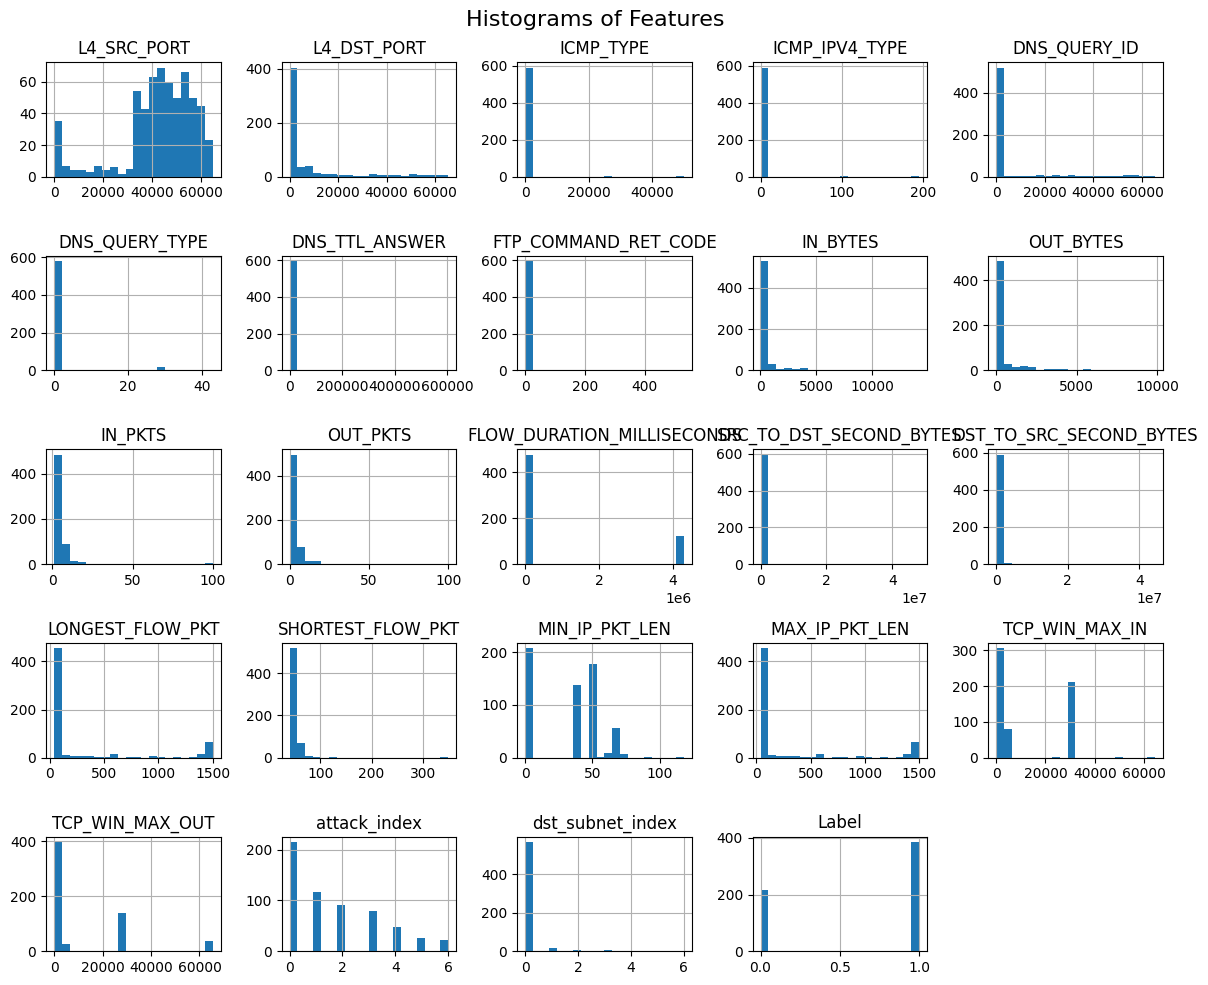

ValueError: could not convert string to float: '192.168.1.32'

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

# Converte il DataFrame Spark in un DataFrame Pandas per l'analisi esplorativa
df_pd = eda_data_train.toPandas()

# Analisi esplorativa dei dati utilizzando Pandas e Seaborn
def eda_analysis(dataframe):
    # Istogrammi delle caratteristiche
    try:
        dataframe.hist(bins=20, figsize=(12, 10))
        plt.suptitle("Histograms of Features", fontsize=16)
        plt.tight_layout()
        plt.show()
    except:
        pass

    # Matrice di correlazione
    correlation_matrix = dataframe.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix', fontsize=16)
    plt.show()

# Esegui l'analisi esplorativa dei dati
eda_analysis(df_pd)